In [1]:
import numpy as np
import pandas as pd
# Recursive Bayesian Estimation
# Kalman Filter
# https://www-oxfordhandbooks-com.stanford.idm.oclc.org/view/10.1093/oxfordhb/9780190213299.001.0001/oxfordhb-9780190213299-e-28
# https://nbviewer.jupyter.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/01-g-h-filter.ipynb
# https://www.johndcook.com/blog/2012/10/29/product-of-normal-pdfs/
# https://ccrma.stanford.edu/~jos/sasp/Product_Two_Gaussian_PDFs.html

# Import polling data
df = pd.read_csv('data.csv', encoding='cp1252')#, index_col = 0)
#df.insert(df.shape[1], "PA_Biden", '')
#df.insert(df.shape[1], "PA_Trump", '')
#df.insert(df.shape[1], "PA_SD", '')


# Dictionary of Electoral College Votes
EC = {  'AK':3, 'AL':9, 'AR':6, 'AZ':11, 'CA':55, 'CO': 9, 'CT':7, 'DE':3, 'FL':29, 'GA':16, \
        'HI':4, 'IA':6, 'ID':4, 'IL':20, 'IN':11, 'KS':6, 'KY':8, 'LA':8, 'MA':11, 'MD':10, \
        'ME':4, 'MI':16, 'MN':10, 'MO':10, 'MS':6, 'MT':3, 'NC':15, 'ND':3, 'NE':5, 'NH':4, \
        'NJ':14, 'NM':5, 'NV':6, 'NY':29, 'OH':18, 'OK':7, 'OR':7, 'PA':20, 'RI':4, 'SC':9, \
        'SD':3, 'TN':11, 'TX':38, 'UT':6, 'VA':13, 'VT':3, 'WA':12, 'WI':10, 'WV':5, 'WY':3, \
        'DC':3}


# List of States
States = (  'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', \
            'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', \
            'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', \
            'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', \
            'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'DC')


In [2]:
def StateElection():
    BidenDelegates = 0
    TrumpDelegates = 0

    for i in range(0, len(States)):
        State = States[i]

        BidenResult = np.random.normal(df.PA_Biden[State], df.PA_SD[State])
        TrumpResult = np.random.normal(df.PA_Trump[State], df.PA_SD[State])

        if BidenResult > TrumpResult:
            BidenDelegates = BidenDelegates + EC[State]
        else:
            TrumpDelegates = TrumpDelegates + EC[State]

    return BidenDelegates, TrumpDelegates


# Description on bayesion updating of gausian / normal PDFs
def BayesianUpdate(PriorMU, PriorSD, LikelihoodMU, LikelihoodSD):
    PosteriorMU = (((PriorSD**2)*(LikelihoodMU)) + ((LikelihoodSD**2)*(PriorMU))) \
        / ((PriorSD**2) + (LikelihoodSD**2))

    PosteriorSD = (((PriorSD**2)*(LikelihoodSD**2)) \
                    / ((PriorSD**2) + (LikelihoodSD**2)))**(1/2)

    return PosteriorMU, PosteriorSD


In [26]:
QtyPolls = 10
Aggregates = pd.DataFrame(columns = ('State','BidenMU','TrumpMU','StandardDeviation'))

print(Aggregates.columns.values)
#aggregation for last QtyPolls where margin of error exists
for i in range(0,len(States)):
    State = States[i]
    
    #Aggregate state polls for polls with margin of error listed
    if (len(df.loc[(df['State'] == State) & (df['MOE'] > 0)]) > 0):
        StatePolls = df.loc[(df['State'] == State) & (df['MOE'] > 0)]

        AggSD = StatePolls.iloc[0,4] / 100 / 1.96
        AggTrumpMU = StatePolls.iloc[0,5]
        AggBidenMU = StatePolls.iloc[0,6]

        for j in range(1, QtyPolls):
            if (j < len(StatePolls)):
                AggBidenMU, ignore = BayesianUpdate(AggBidenMU, AggSD, StatePolls.iloc[j,6], StatePolls.iloc[j,4] / 1.96)
                AggTrumpMU, AggSD = BayesianUpdate(AggTrumpMU, AggSD, StatePolls.iloc[j,5], StatePolls.iloc[j,4] / 1.96)

        row = pd.DataFrame([[State, AggBidenMU, AggTrumpMU, AggSD]], columns = Aggregates.columns.values)
        Aggregates = pd.concat([Aggregates, row])
        
    #for states with no margin of error listed, set equal to latest poll with .02 standard deviation
    else:
        StatePolls = df.loc[(df['State'] == State)]
        AggSD = .02
        AggTrumpMU = StatePolls.iloc[0,5]
        AggBidenMU = StatePolls.iloc[0,6]

        row = pd.DataFrame([[State, AggBidenMU, AggTrumpMU, AggSD]], columns = Aggregates.columns.values)
        Aggregates = pd.concat([Aggregates, row])


['State' 'Biden MU' 'Trump MU' 'Standard Deviation']


,State,Biden MU,Trump MU,Standard Deviation
0,AK,0.390056,0.450023,0.029069
0,AL,0.370011,0.569988,0.020403
0,AR,0.450000,0.470000,0.016837
0,AZ,0.489984,0.469980,0.021926
0,CA,0.590144,0.339839,0.027508


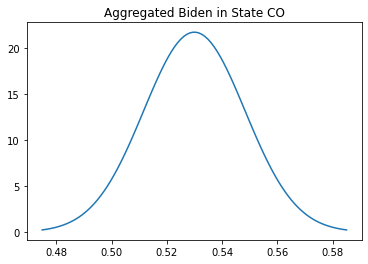

"\nplt.title('Aggregated ' + States[i])\nB_MU = Results[i,1]\nT_MU = Results[i,2]\nSD = Results[i,3]\nB = np.linspace(B_MU - 3*SD, B_MU + 3*SD, 100)\nT = np.linspace(T_MU - 3*SD, T_MU + 3*SD, 100)\nplt.plot(B, stats.norm.pdf(B, B_MU, SD), color = 'b')\nplt.plot(T, stats.norm.pdf(T, T_MU, SD), color = 'r')\nplt.show()\n"

In [35]:
import matplotlib.pyplot as plt
import scipy.stats as stats

i = 5
State = States[i]

StatePolls = df.loc[(df['State'] == State) & (df['MOE'] > 0)]

#print(StatePolls)
B_MU_1 = StatePolls.iloc[0,6]
SD_1 = StatePolls.iloc[0,4] / 100 / 1.96
B_MU_2 = StatePolls.iloc[1,6]
SD_2 = StatePolls.iloc[1,4] / 100 / 1.96
B_MU_3 = StatePolls.iloc[2,6]
SD_3 = StatePolls.iloc[2,4] / 100 / 1.96

BA_MU = Aggregates.iloc[i,1]
SDA   = Aggregates.iloc[i,3]
#print(Results)

plt.title('Aggregated Biden in State ' + State)
B1 = np.linspace(B_MU_1 - 3*SD_1, B_MU_1 + 3*SD_1, 100)
B2 = np.linspace(B_MU_2 - 3*SD_2, B_MU_2 + 3*SD_2, 100)
B3 = np.linspace(B_MU_3 - 3*SD_3, B_MU_3 + 3*SD_3, 100)
BA = np.linspace(BA_MU - 3*SDA, BA_MU + 3*SDA, 100)
#plt.plot(B1, stats.norm.pdf(B1, B_MU_1, SD_1))
#plt.plot(B2, stats.norm.pdf(B2, B_MU_2, SD_2))
#plt.plot(B3, stats.norm.pdf(B3, B_MU_3, SD_3))
plt.plot(BA, stats.norm.pdf(BA, BA_MU, SDA))
plt.show()


# Aggregated Biden vs. Trump
'''
plt.title('Aggregated ' + States[i])
B_MU = Results[i,1]
T_MU = Results[i,2]
SD = Results[i,3]
B = np.linspace(B_MU - 3*SD, B_MU + 3*SD, 100)
T = np.linspace(T_MU - 3*SD, T_MU + 3*SD, 100)
plt.plot(B, stats.norm.pdf(B, B_MU, SD), color = 'b')
plt.plot(T, stats.norm.pdf(T, T_MU, SD), color = 'r')
plt.show()
'''